<a href="https://colab.research.google.com/github/kimberley-faria/implicit-hate-detection/blob/main/implicit_hate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup a git repo in your google drive - https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

(I did this in a separate notebook, so I can keep this one free of git commit/push etc commands)

In [ ]:
# if local
# !conda activate cs685

/bin/bash: conda: command not found


In [ ]:
BASE_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection'
DATA_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-corpus'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
os.path.dirname(sys.executable)

'/usr/bin'

In [ ]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = BASE_PATH
else:
    base_path = r'C:\Users\faria\PycharmProjects\685\project\implicit-hate-detection'
    DATA_PATH = r'C:\Users\faria\PycharmProjects\685\project\data\implicit-hate-corpus-nov-2021\implicit-hate-corpus'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


switch to the git repo in your drive

In [ ]:
%cd $base_path
# !git checkout 5-bert-baselines-bin-classification-hate-non-hate

/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection


In [ ]:
# !git status

install requirements from repo 

In [ ]:
# for colab, use venv if in local
!pip install -r requirements.txt

     |████████████████████████████████| 4.0 MB 7.2 MB/s 
     |████████████████████████████████| 1.8 MB 41.3 MB/s 
     |████████████████████████████████| 596 kB 48.3 MB/s 
     |████████████████████████████████| 880 kB 56.2 MB/s 
     |████████████████████████████████| 6.6 MB 54.3 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/s 
     |████████████████████████████████| 181 kB 72.2 MB/s 
     |████████████████████████████████| 145 kB 39.4 MB/s 
     |████████████████████████████████| 63 kB 2.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=c69da29af8fdbae2d7318db2c786d474c783f5a463c178436954950b8814f3b2
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=f2b03f77630fe2617536f66ca7a6e49882cd915a3722e4d9126ac5f6920f6a73
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83ee

load the helper and dataloader files

In [ ]:
%load implicit_hate_dataloader/dataloader.py    
%load implicit_hate_dataloader/helpers.py

In [ ]:
import torch
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla P100-PCIE-16GB, n_gpu: 1


In [ ]:
import numpy as np
import random
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import os


def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
      torch.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
      os.environ['PYTHONHASHSEED'] = str(seed)
      # safe to call this function even if cuda is not available
    if is_tf_available():
      import tensorflow as tf
      tf.random.set_seed(seed)

set_seed(70)

In [ ]:

data_path = DATA_PATH
dataset_filename = {
    # post (str)
    # class (str): high-level label in {`explicit_hate`,`implicit_hate`,`not_hate`}
    "stage-1": os.path.join(data_path, "implicit_hate_v1_stg1_posts.tsv"),

    # post (str)
    # class (str): fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`}
    # extra_implicit_class: (str) A secondary fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`, **None**}
    "stage-2": os.path.join(data_path, "implicit_hate_v1_stg2_posts.tsv"),

    # post (str)
    # target: (str) Free-text annotation for the group being targeted (e.g. `Black people`, `Immigrants`, etc.)
    # implied_statement: (str) Free-text annotation for the implicit or hidden underlying meaning of the post made
    # explicit (e.g. `people in minority groups are all in gangs`)
    "stage-3": os.path.join(data_path, "implicit_hate_v1_stg3_posts.tsv")
}

In [ ]:
from implicit_hate_dataloader.dataloader import Stage1Dataset, Stage2Dataset
from torch.utils.data import DataLoader

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

implicit_hate_dataset = Stage2Dataset(dataset_filename["stage-2"], drop_other=True)

labels = implicit_hate_dataset.implicit_classes
# splitting into train and test set
train_idx, test_idx= train_test_split(np.arange(len(labels)), test_size=0.2, shuffle=True, stratify=labels)
print(len(labels), len(train_idx), len(test_idx))
train_idx.sort()
print(np.arange(len(labels)))
print(train_idx)

# splitting into train and val set from train indices 
train_labels = list(map(labels.__getitem__, train_idx))
train_idx, val_idx= train_test_split(train_idx, test_size=0.25, shuffle=True, stratify=train_labels)
print(len(train_idx), len(val_idx))

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=train_sampler)

# test_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=test_sampler)

6266 5012 1254
[   0    1    2 ... 6263 6264 6265]
[   0    1    2 ... 6260 6262 6265]
3759 1253


In [ ]:
# Confirming type is tensor
text, _, _, input_ids, attention_masks, labels, _ = next(iter(train_dataloader))
print(type(input_ids), type(attention_masks), type(labels))

print(text)

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
(' if you\'re white  you don\'t need to  " join " " anything . your skin is your uniform . have white children and teach the our culture "', "it's mexifornia, land of hemp fields and socialistsvery anti-citizen and pro-illegals", 'close border, or bring our soldiers back home to protect the taxpayers!', ': and as poor as they are  the predominantly white areas are still safer .', 'may he rest in peace . i didnt know him  i bet he was a good man . stood for what was right  the white race .', "so is the white hating  jew hating cult  the nation of islam . what's your point ?", ' european  " refugee " " crisis worsens #wakeupamerica #whitelivesmatter "', 'it seems people are willing to sell the future of western children for a momentary feeling of misguided moral superiority .')


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
# function to get validation accuracy
def get_validation_performance(model, val_idx, config, epoch, dataset):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    validation_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=sampler)

    total_correct = 0

    predicted = []
    labels = []

    for batch in validation_dataloader:

      input_id_tensors = batch[3]
      input_mask_tensors = batch[4]
      label_tensors = batch[5]
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
        predicted.append(pred_flat)
        labels.append(labels_flat)      

        
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_idx)
    final_score = precision_recall_fscore_support(predicted, labels, average='macro')
    class_names=['white_grievance', 'incitement', 'inferiority', 'irony', 'stereotypical', 'threatening']
    wandb.log({f"conf_mat_{dataset}_{epoch}" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels, preds=predicted,
                        class_names=class_names)})
    cm = confusion_matrix(labels, predicted, labels=[0, 1, 2, 3, 4, 5])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=class_names)
    disp.plot()

    wandb.log({f"conf_mat_matplotlib_{dataset}_{epoch}": plt})
    plt.show()

    return avg_val_accuracy, final_score

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

# hyperparameters used in original paper
sweep_config = {
    "name": "implicit_hate_detection_multi_class",
    "method" : "grid",
    "parameters" : {
        "batch_size": {
            "values" : [8]
        },
        "learning_rate" : {
            "values": [1e-5, 2e-5, 3e-5, 5e-5]
        },
        "random_seed" : {
          "values": [37, 69, 42]    
        },
        "epochs" : {
            "values" : [4]
        },
        "epsilon": {
            "values" : [1e-8]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, entity="umass-iesl-is", project="cs685-project")
# sweep_id = "gwbynpx8"

Create sweep with ID: mmh0wqsi
Sweep URL: https://wandb.ai/umass-iesl-is/cs685-project/sweeps/mmh0wqsi


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

def train():
    with wandb.init() as run:
        config = wandb.config
        
        model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 6, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        # Tell pytorch to run this model on the GPU.
        model.cuda()


        optimizer = AdamW(model.parameters(),
                        lr = config["learning_rate"], # args.learning_rate - default is 5e-5
                        eps = config["epsilon"] # args.adam_epsilon  - default is 1e-8
                        )
        wandb.watch(model, log="all")

        set_seed(config['random_seed'])
        best_val = 0

        for epoch_i in range(0, config["epochs"]):
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, config["epochs"]))
            print('Training...')

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            train_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=train_sampler)

            for batch_idx, batch in enumerate(train_dataloader):

                input_id_tensors = batch[3]
                input_mask_tensors = batch[4]
                label_tensors = batch[5]

                # Move tensors to the GPU
                b_input_ids = input_id_tensors.to(device)
                b_input_mask = input_mask_tensors.to(device)
                b_labels = label_tensors.to(device)

                # Clear the previously calculated gradient
                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Update parameters and take a step using the computed gradient.
                optimizer.step()
                wandb.log({
                    "batch_loss": loss.item(),
                    "batch": batch_idx
                })
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set. Implement this function in the cell above.
            print(f"Total loss: {total_train_loss}")
            val_acc, (val_precision, val_recall, val_f1, val_hash) = get_validation_performance(model, val_idx, config, epoch_i, "val")

            if val_acc > best_val:
              best_val = val_acc
              best_model = model
              best_lr = config["learning_rate"]
              best_randomseed = config["random_seed"]
              torch.save(model.state_dict(), 'best-model-parameters.pt')
              wandb.run.summary["best_lr"] = best_lr
              wandb.run.summary["best_randomseed"] = best_randomseed
              wandb.run.summary["best_val"] = best_val

            print(val_precision, val_recall, val_f1)
            print(f"Validation accuracy: {val_acc}")

            wandb.log({
                "loss": total_train_loss, 
                "epoch": config["epochs"], 
                "val_acc": val_acc,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1
                })
            
        print("")
        print("Training complete!")

        test_acc, (test_precision, test_recall, test_f1, test_hash) = get_validation_performance(best_model, test_idx, config, 0, "test")
        print(test_precision, test_recall, test_f1)
        print(f"Test accuracy: {test_acc}")
        wandb.log({
            "test_acc": test_acc,
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1
            })

        # torch.save(model.state_dict(), "model.h5")
        # wandb.save('model.h5')

wandb: Agent Starting Run: v56rke5j with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 689.5896694660187


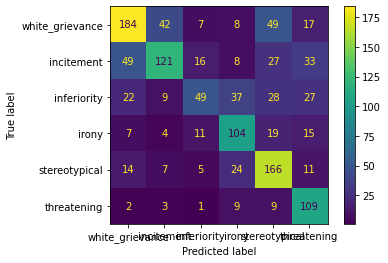

0.5935727688513652 0.5802560466788605 0.5688482468167625
Validation accuracy: 0.5849960095770151

======== Epoch 2 / 4 ========
Training...
Total loss: 477.72728204727173


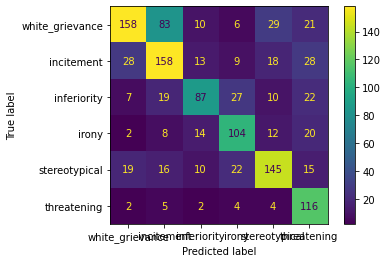

0.633911024831749 0.6183685777657847 0.6138010379783639
Validation accuracy: 0.6129289704708699

======== Epoch 3 / 4 ========
Training...
Total loss: 327.40131521224976


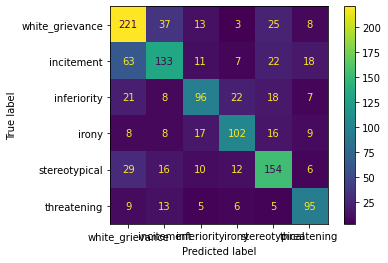

0.6386385166950367 0.6428113651236865 0.6388783588939897
Validation accuracy: 0.6392657621707901

======== Epoch 4 / 4 ========
Training...
Total loss: 199.48053250461817


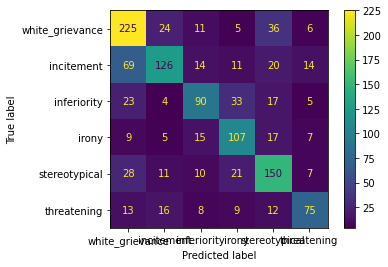

0.6076117591431194 0.6211680218841481 0.6091620699944783
Validation accuracy: 0.6169193934557063

Training complete!


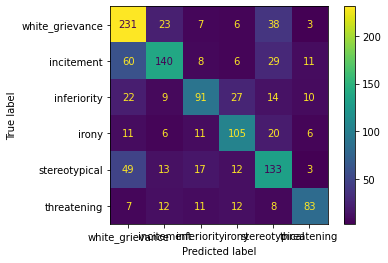

0.6162555426037988 0.6358733557318774 0.6220938031081357
Test accuracy: 0.6244019138755981


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,█▇▇█▅▆▇▅▆▆▅▆▄▄▆▇▇▄▄▃▃▂▃▃▃▂▄▃▅▃▄▃▃▃▂▃▃▂▂▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▅█▅
val_f1,▁▅█▅
val_precision,▁▇█▃


wandb: Agent Starting Run: 4i4z8tlf with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 706.8035416603088


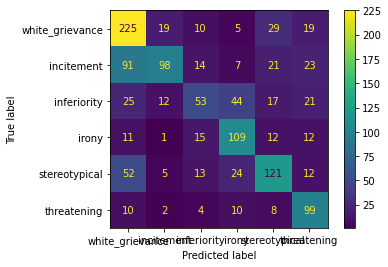

0.5642526465285498 0.5677954645578628 0.5478149923595848
Validation accuracy: 0.5626496408619314

======== Epoch 2 / 4 ========
Training...
Total loss: 488.09298262000084


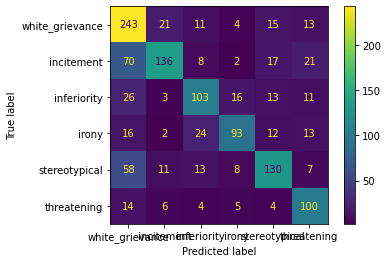

0.6386030247852664 0.6623360676949043 0.6407016792788179
Validation accuracy: 0.6424581005586593

======== Epoch 3 / 4 ========
Training...
Total loss: 330.031700104475


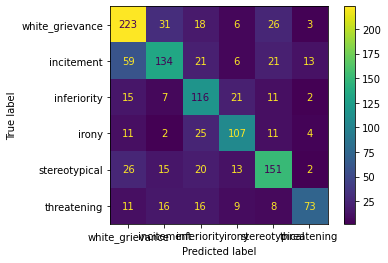

0.6351970738211183 0.6520707056198525 0.6381633942418402
Validation accuracy: 0.641660015961692

======== Epoch 4 / 4 ========
Training...
Total loss: 195.69159154593945


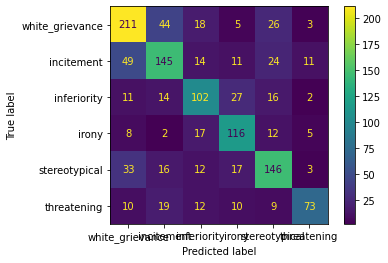

0.6280383001838127 0.6408576647092681 0.6309887394897338
Validation accuracy: 0.6328810853950518

Training complete!


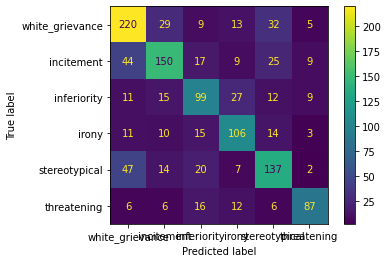

0.6335695774559356 0.642170373410008 0.6363530303534004
Test accuracy: 0.6371610845295056


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,▇██▇▇▇█▅▅▆▄▄▄▅▅▅▆▇▆▅▃▂▂▂▃▂▃▄▄▂▁▃▂▂▃▁▄▁▂▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁██▇
val_f1,▁██▇
val_precision,▁██▇


wandb: Agent Starting Run: y6khcnqt with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 692.8747190833092


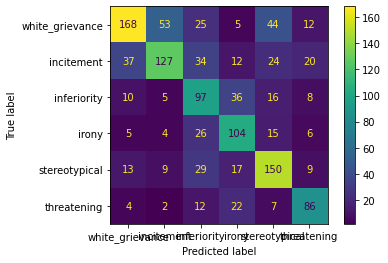

0.594765708604272 0.5842195268135252 0.5835637610982843
Validation accuracy: 0.5841979249800479

======== Epoch 2 / 4 ========
Training...
Total loss: 477.91606268286705


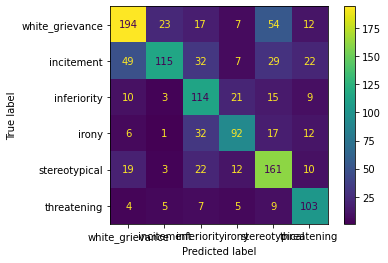

0.634359269806269 0.6300724846987446 0.6203938216136538
Validation accuracy: 0.62170790103751

======== Epoch 3 / 4 ========
Training...
Total loss: 325.07379999756813


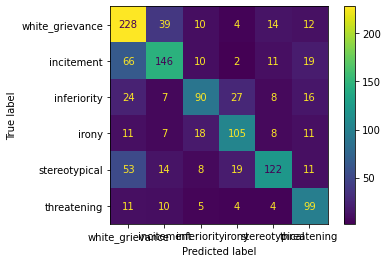

0.6297976349180198 0.6408596022934008 0.6283283382202939
Validation accuracy: 0.6304868316041501

======== Epoch 4 / 4 ========
Training...
Total loss: 195.17095158994198


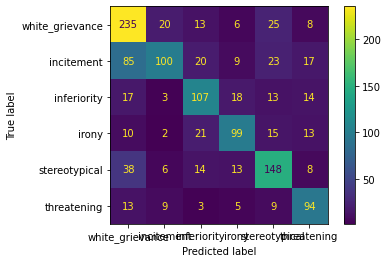

0.6264609032514717 0.6352407190891143 0.6204916090650817
Validation accuracy: 0.6249002394253791

Training complete!


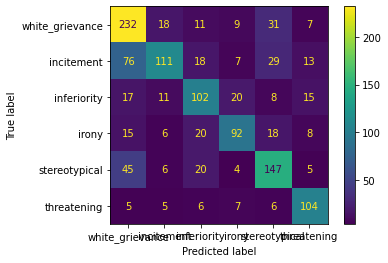

0.6313330558192268 0.6398821903597354 0.6276558481061156
Test accuracy: 0.6283891547049442


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,████▇▆▆▆▄▆▇▅▇▆▄▄▆▅▆▇▅▃▄▆▂▃▃▄▅▁▄▂▂▁▃▂▁▃▁▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▇█▇
val_f1,▁▇█▇
val_precision,▁█▇▇


wandb: Agent Starting Run: 4jnfzpa7 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 674.2882941961288


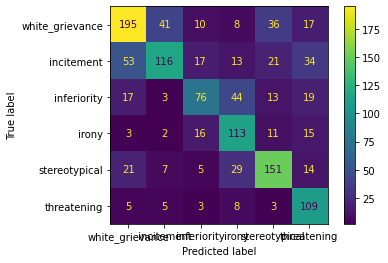

0.6207882736104137 0.603421703002695 0.5991630426712179
Validation accuracy: 0.6065442936951316

======== Epoch 2 / 4 ========
Training...
Total loss: 430.1812504529953


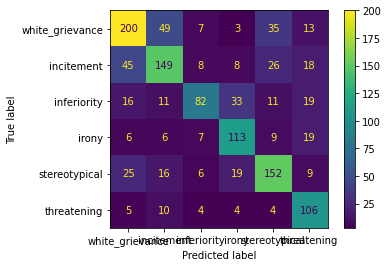

0.6479450271254238 0.642695187615913 0.6377244072183812
Validation accuracy: 0.6400638467677574

======== Epoch 3 / 4 ========
Training...
Total loss: 240.8567574545741


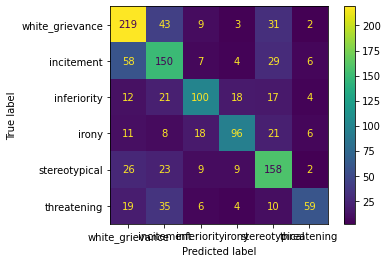

0.6041576406077743 0.649812691649834 0.6178780803868643
Validation accuracy: 0.6241021548284118

======== Epoch 4 / 4 ========
Training...
Total loss: 108.38449691422284


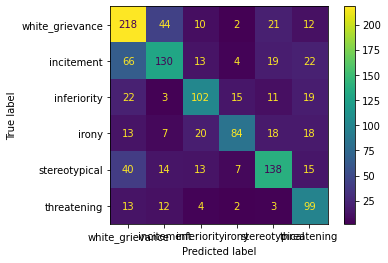

0.6153704028299748 0.6273031419324572 0.6134338632443094
Validation accuracy: 0.6153232242617718

Training complete!


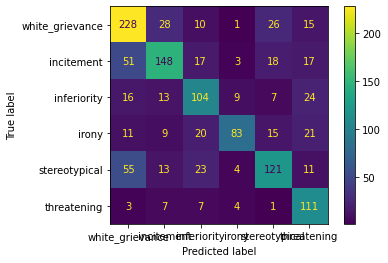

0.6356219445561818 0.6465568722297811 0.6293744383746914
Test accuracy: 0.6339712918660287


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,█▇▆▆▆▇█▅▅▆▄▄▃▄▅▅▆▅▄▃▃▃▂▂▂▂▄▄▄▁▃▁▃▂▁▂▃▁▁▂
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▅▃
val_f1,▁█▄▄
val_precision,▄█▁▃


wandb: Agent Starting Run: meqjwty2 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 645.9527300298214


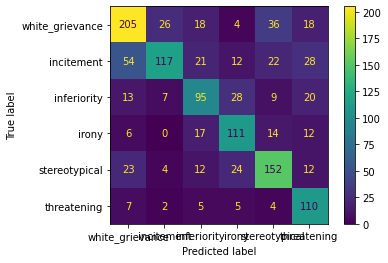

0.6451881898423235 0.6292786144327147 0.6262339691764285
Validation accuracy: 0.6304868316041501

======== Epoch 2 / 4 ========
Training...
Total loss: 396.5582320988178


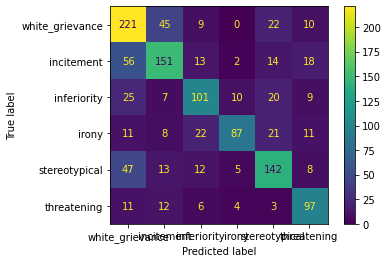

0.6333651945343298 0.6557219775252042 0.6385535204700096
Validation accuracy: 0.6376695929768555

======== Epoch 3 / 4 ========
Training...
Total loss: 208.0659308284521


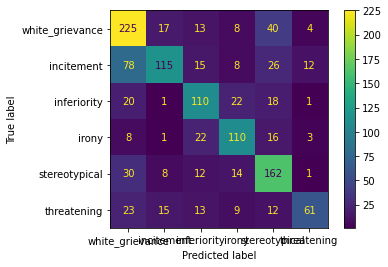

0.6141654693734326 0.6485723899609473 0.6176480534608835
Validation accuracy: 0.6249002394253791

======== Epoch 4 / 4 ========
Training...
Total loss: 100.21191717125475


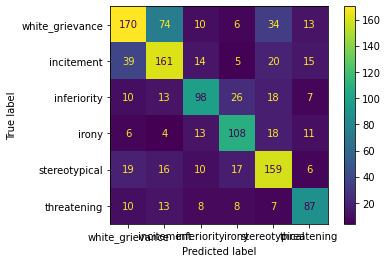

0.6311579174826648 0.6275091832128455 0.6272738530136887
Validation accuracy: 0.6249002394253791

Training complete!


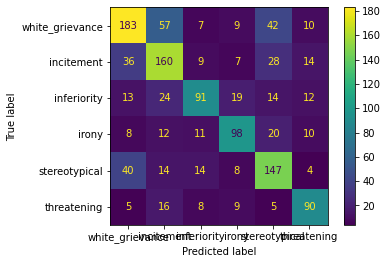

0.6151182812973647 0.6213142523472256 0.6161523345780731
Test accuracy: 0.613237639553429


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,██▇▇▇▆▇▅▄▇▃▃▄▄▅▄▅▇▆▅▂▂▂▂▂▂▁▂▅▁▁▂▁▁▃▁▅▁▁▂
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▄█▁▁
val_f1,▄█▁▄
val_precision,█▅▁▅


wandb: Agent Starting Run: 3tu72h01 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 638.370788037777


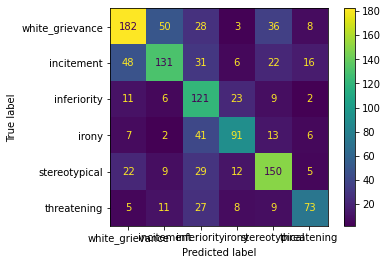

0.5984142353005938 0.6088417679410058 0.5959232866180356
Validation accuracy: 0.5969672785315243

======== Epoch 2 / 4 ========
Training...
Total loss: 401.28888837993145


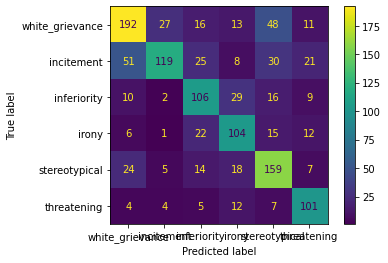

0.6366715329623428 0.6261187155445241 0.6230359277411657
Validation accuracy: 0.6233040702314445

======== Epoch 3 / 4 ========
Training...
Total loss: 219.05905021727085


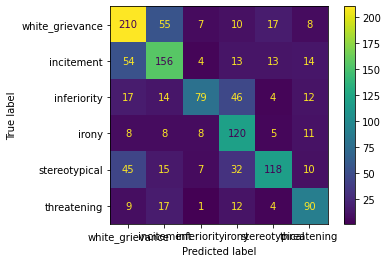

0.6173383599575498 0.6358062551947322 0.6136786165381133
Validation accuracy: 0.6169193934557063

======== Epoch 4 / 4 ========
Training...
Total loss: 104.68197226338089


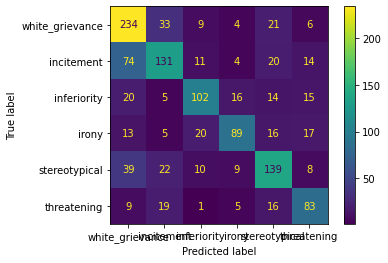

0.6106052038602376 0.628960439747083 0.6156810606773583
Validation accuracy: 0.6209098164405427

Training complete!


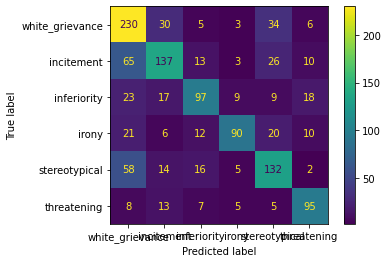

0.6181063691005834 0.6477237773541833 0.6267779804119579
Test accuracy: 0.6228070175438597


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,██▇▇▇▇▄▆▄▅▇▅▇▆▄▄▅▇▆▆▄▄▃▆▁▃▂▃▄▁▂▁▁▁▃▁▁▂▁▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▆▇
val_f1,▁█▆▆
val_precision,▁█▄▃


wandb: Agent Starting Run: 80wuiz0o with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 628.352610886097


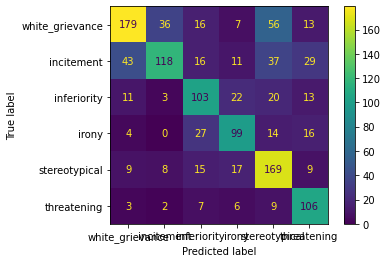

0.6344503168267485 0.6200578136560198 0.6163214382348553
Validation accuracy: 0.6177174780526736

======== Epoch 2 / 4 ========
Training...
Total loss: 387.54801793396473


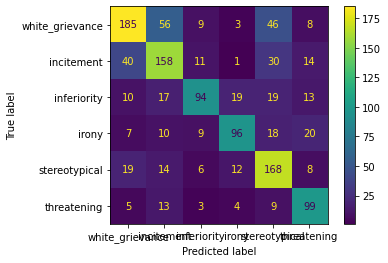

0.6426022905293598 0.6497824566302504 0.6402410803503095
Validation accuracy: 0.6384676775738228

======== Epoch 3 / 4 ========
Training...
Total loss: 194.55091812089086


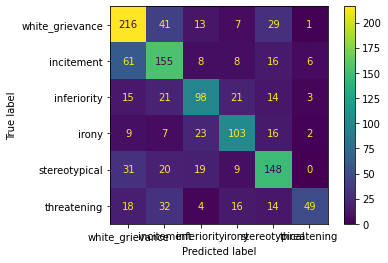

0.5912900259513935 0.6380794161388099 0.6004884039389601
Validation accuracy: 0.6137270550678372

======== Epoch 4 / 4 ========
Training...
Total loss: 87.97300237324089


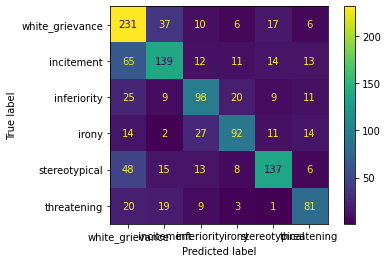

0.6095002197595321 0.6303955196793781 0.6160618308369032
Validation accuracy: 0.6209098164405427

Training complete!


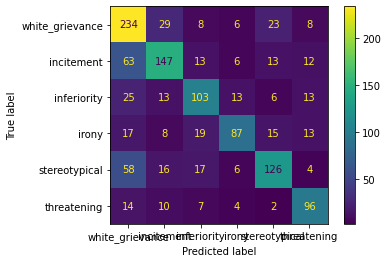

0.6263160902763386 0.6495054066043652 0.632029699646152
Test accuracy: 0.6323763955342903


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,█▇▆▇▆▆▇▄▅▆▄▃▂▄▅▄▅▄▃▂▃▃▂▂▂▃▃▂▃▁▄▁▁▂▂▂▂▁▁▂
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▂█▁▃
val_f1,▄█▁▄
val_precision,▇█▁▃


wandb: Agent Starting Run: nwv78tx2 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 641.1182646453381


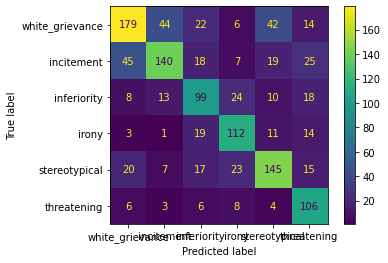

0.6409305646647755 0.6179788645157049 0.6235946344045681
Validation accuracy: 0.6233040702314445

======== Epoch 2 / 4 ========
Training...
Total loss: 392.26111452281475


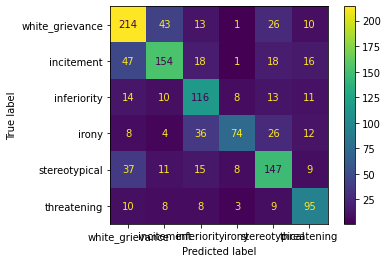

0.633691504659185 0.6493470040999542 0.6329414813191157
Validation accuracy: 0.6384676775738228

======== Epoch 3 / 4 ========
Training...
Total loss: 191.8325940966606


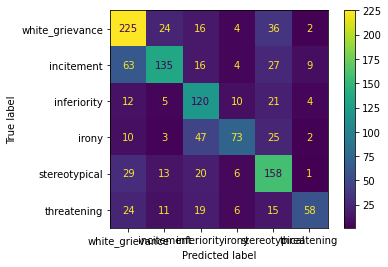

0.5917408287087899 0.643837020149393 0.5991218947296076
Validation accuracy: 0.6137270550678372

======== Epoch 4 / 4 ========
Training...
Total loss: 86.70417127665132


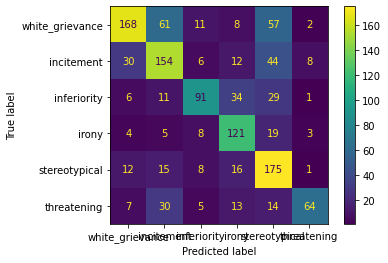

0.6151630613415913 0.654083465546526 0.6171790829496602
Validation accuracy: 0.6169193934557063

Training complete!


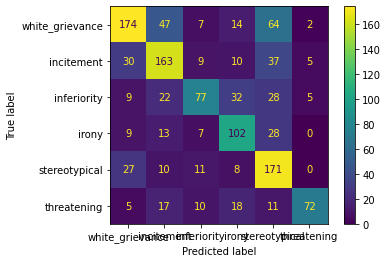

0.5979868059634273 0.6394305290526009 0.6042309013497408
Test accuracy: 0.6052631578947368


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,██▇█▇▆▇▄▃▇▂▃▅▄▅▃▅▇▅▅▂▁▂▂▂▂▁▄▂▁▁▂▁▁▁▂▄▁▁▂
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▄█▁▂
val_f1,▆█▁▅
val_precision,█▇▁▄


wandb: Agent Starting Run: v9jul6yd with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 622.3744129836559


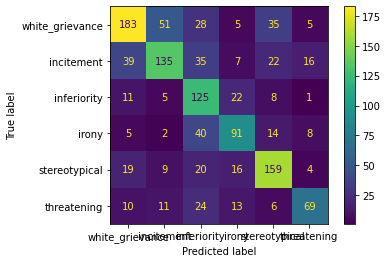

0.6070531625609881 0.615201041108422 0.6030625026839398
Validation accuracy: 0.6081404628890662

======== Epoch 2 / 4 ========
Training...
Total loss: 380.64460127055645


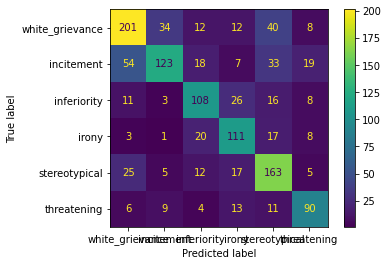

0.642564245936012 0.6374396269607132 0.6348001121626097
Validation accuracy: 0.6352753391859537

======== Epoch 3 / 4 ========
Training...
Total loss: 191.80364813655615


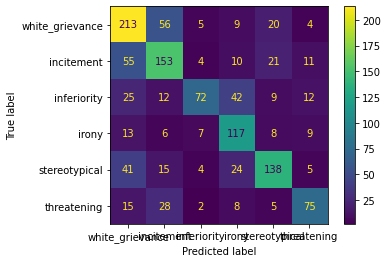

0.6029778701100599 0.6352139414983864 0.6069660056044489
Validation accuracy: 0.6129289704708699

======== Epoch 4 / 4 ========
Training...
Total loss: 88.61670139897615


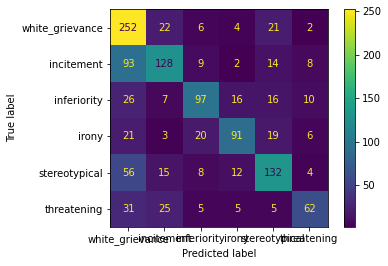

0.5841917687790384 0.6411092922571421 0.6006796094358149
Validation accuracy: 0.6081404628890662

Training complete!


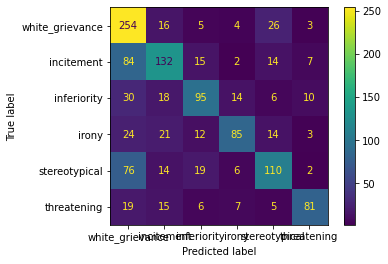

0.5869480935298617 0.6451221735130465 0.6040195973155993
Test accuracy: 0.6036682615629984


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,█▇▇▆▆▆▄▅▄▅▇▄▇▆▄▅▅▇▆▆▄▃▃▄▃▃▃▄▄▂▂▁▁▁▁▁▂▂▁▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▂▁
val_f1,▁█▂▁
val_precision,▄█▃▁


wandb: Agent Starting Run: 68y176sw with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 5e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 622.4436999559402


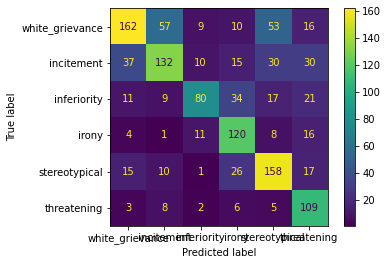

0.6296787882213307 0.6146354507663574 0.6069819263651361
Validation accuracy: 0.6073423782920989

======== Epoch 2 / 4 ========
Training...
Total loss: 387.41098818182945


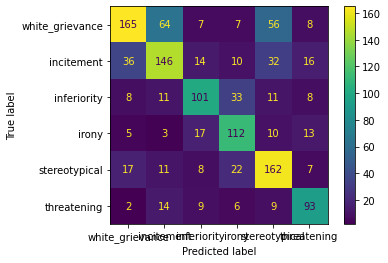

0.6353960405475755 0.625226701421092 0.6259332784825592
Validation accuracy: 0.62170790103751

======== Epoch 3 / 4 ========
Training...
Total loss: 194.529474388808


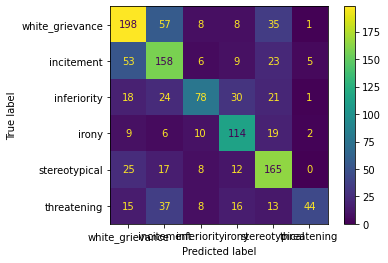

0.5817810117696444 0.6405459869347329 0.5875727721185515
Validation accuracy: 0.6041500399042299

======== Epoch 4 / 4 ========
Training...
Total loss: 113.0641952981241


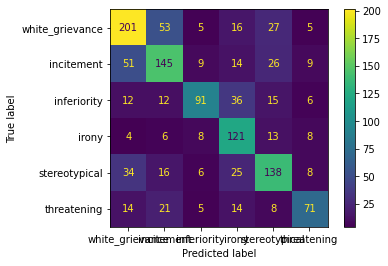

0.608778856349107 0.6249914323549083 0.6097768350161781
Validation accuracy: 0.6121308858739026

Training complete!


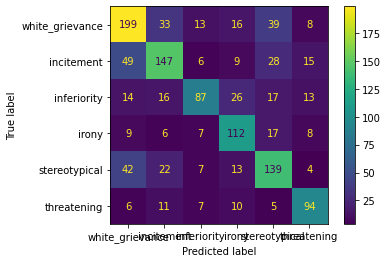

0.6252064102955389 0.6276441739631416 0.6229817517832651
Test accuracy: 0.620414673046252


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,██▆█▆▇▇▄▅▇▃▃▃▄▅▆▅▄▄▂▄▁▂▁▁▃▂▁▄▂▃▂▂▂▁▄▂▁▁▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▂█▁▄
val_f1,▅█▁▅
val_precision,▇█▁▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hjyozmos with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 5e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 630.1281645298004


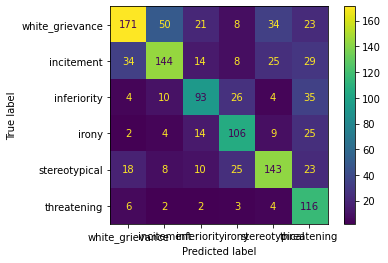

0.6382110773117078 0.618249715884084 0.6146821002880001
Validation accuracy: 0.6169193934557063

======== Epoch 2 / 4 ========
Training...
Total loss: 388.1421462893486


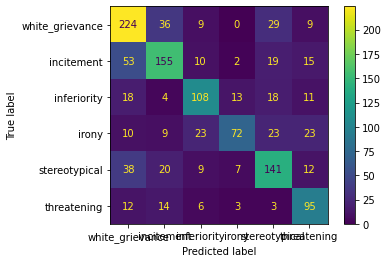

0.625535996627126 0.6433279509711761 0.6264511117925013
Validation accuracy: 0.6344772545889864

======== Epoch 3 / 4 ========
Training...
Total loss: 196.22919125668705


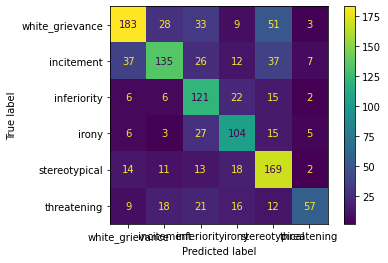

0.6090234101564648 0.6301944275547416 0.6047698887908425
Validation accuracy: 0.6137270550678372

======== Epoch 4 / 4 ========
Training...
Total loss: 106.76026239432395


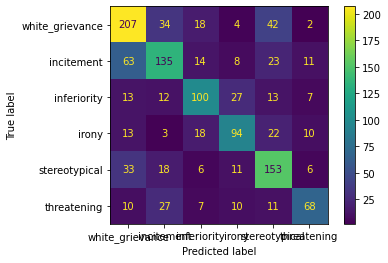

0.5933242531446572 0.6095695451630211 0.5987786182203563
Validation accuracy: 0.6041500399042299

Training complete!


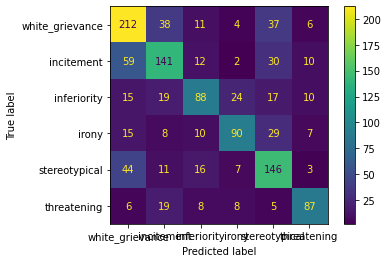

0.6025741998569075 0.6225594709498479 0.6098342492308301
Test accuracy: 0.6092503987240829


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,██▇▇▇▅█▅▃▆▂▂▄▄▄▄▆▅▄▅▂▁▂▃▁▂▃▃▃▁▂▃▁▂▁▃▄▃▂▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▄█▃▁
val_f1,▅█▃▁
val_precision,█▆▃▁


wandb: Agent Starting Run: pzce00la with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 5e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 620.0432405769825


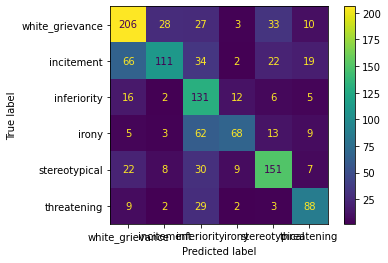

0.6035829877005452 0.6305678726434554 0.596948074171121
Validation accuracy: 0.6025538707102953

======== Epoch 2 / 4 ========
Training...
Total loss: 387.3483986258507


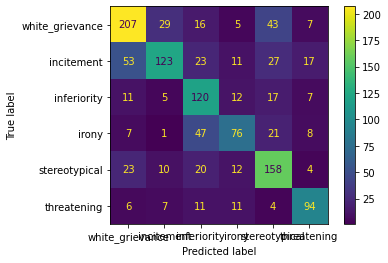

0.6223326079449615 0.6255325211092141 0.6160364417982384
Validation accuracy: 0.6209098164405427

======== Epoch 3 / 4 ========
Training...
Total loss: 207.3325394615531


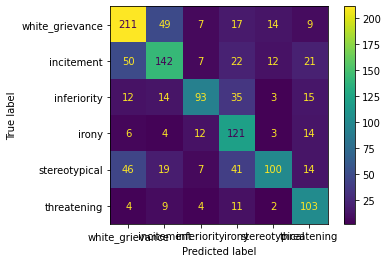

0.6263773223422915 0.6295420985833541 0.6121842232281512
Validation accuracy: 0.6145251396648045

======== Epoch 4 / 4 ========
Training...
Total loss: 117.02661805320531


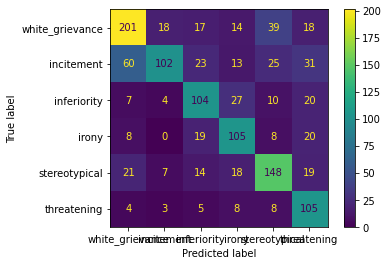

0.6264425260068811 0.6137951235333824 0.6044532060025603
Validation accuracy: 0.6105347166799681

Training complete!


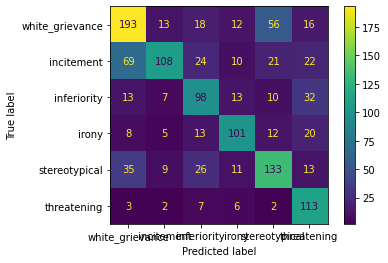

0.6148402475155605 0.6049637936379292 0.5957256569320462
Test accuracy: 0.594896331738437


batch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▅▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▄▄▅▆▇▇█
batch_loss,█▇▆▆▆▇▄▅▃▅▆▅█▆▃▅▄▇▅▅▄▂▄▆▁▃▂▅▄▂▂▁▁▁▄▂▁▁▁▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▆▄
val_f1,▁█▇▄
val_precision,▁▇██


In [ ]:
count = 12 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count, entity="umass-iesl-is", project="cs685-project")